<a href="https://colab.research.google.com/github/dhasaf/Classification/blob/main/FlightPricePrediction3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flight price prediction**
### Our goal is to build supervised Natural Language Processing (NLP) machine learning models to predict the price of a flight.

### **Import Libaries**

In [607]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

### **Load the data**

In [608]:
flight = pd.read_csv("Flight_price.csv")
flight.head()

,number,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Take a 100,000 sample

In [609]:
flight = flight.sample(n=1000, random_state=42)

### **View data**

In [610]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 27131 to 75274
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            1000 non-null   int64  
 1   airline           1000 non-null   object 
 2   flight            1000 non-null   object 
 3   source_city       1000 non-null   object 
 4   departure_time    1000 non-null   object 
 5   stops             1000 non-null   object 
 6   arrival_time      1000 non-null   object 
 7   destination_city  1000 non-null   object 
 8   class             1000 non-null   object 
 9   duration          1000 non-null   float64
 10  lead_reservation  1000 non-null   int64  
 11  price             1000 non-null   int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 101.6+ KB


In [611]:
flight.describe()

,number,duration,lead_reservation,price
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,144905.771000,12.169290,25.882000,20020.685000
std,87018.045615,7.172312,13.599302,22496.083452
min,49.000000,1.080000,1.000000,1105.000000
25%,69877.000000,6.670000,14.000000,4823.750000
50%,143671.000000,11.250000,25.000000,7021.000000
75%,218396.750000,16.020000,38.000000,41269.000000
max,300089.000000,36.830000,49.000000,98839.000000


In [612]:
flight.shape

(1000, 12)

**Check number of null values**

In [613]:
flight.isnull().sum()

number              0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
lead_reservation    0
price               0
dtype: int64

Check duplicates 

In [614]:
flight.duplicated().sum()

0

number of unique data for each feature

In [615]:
flight.nunique()

number              1000
airline                6
flight               449
source_city            6
departure_time         6
stops                  3
arrival_time           6
destination_city       6
class                  2
duration             290
lead_reservation      49
price                662
dtype: int64

As we understand from the result above, the "number" column is an index since its unique values are just like the size of our dataset, which is 300153.
So, it will be dropped from our dataset.

In [616]:
flight.drop(["number"], axis=1, inplace=True)

In [617]:
flight.drop(["flight"], axis=1, inplace=True)

In [618]:
flight.shape

(1000, 10)

convert price from int to float

In [619]:
flight['price'] = flight['price'].astype(float)

**Draw histogram to view the numeric values distribution**

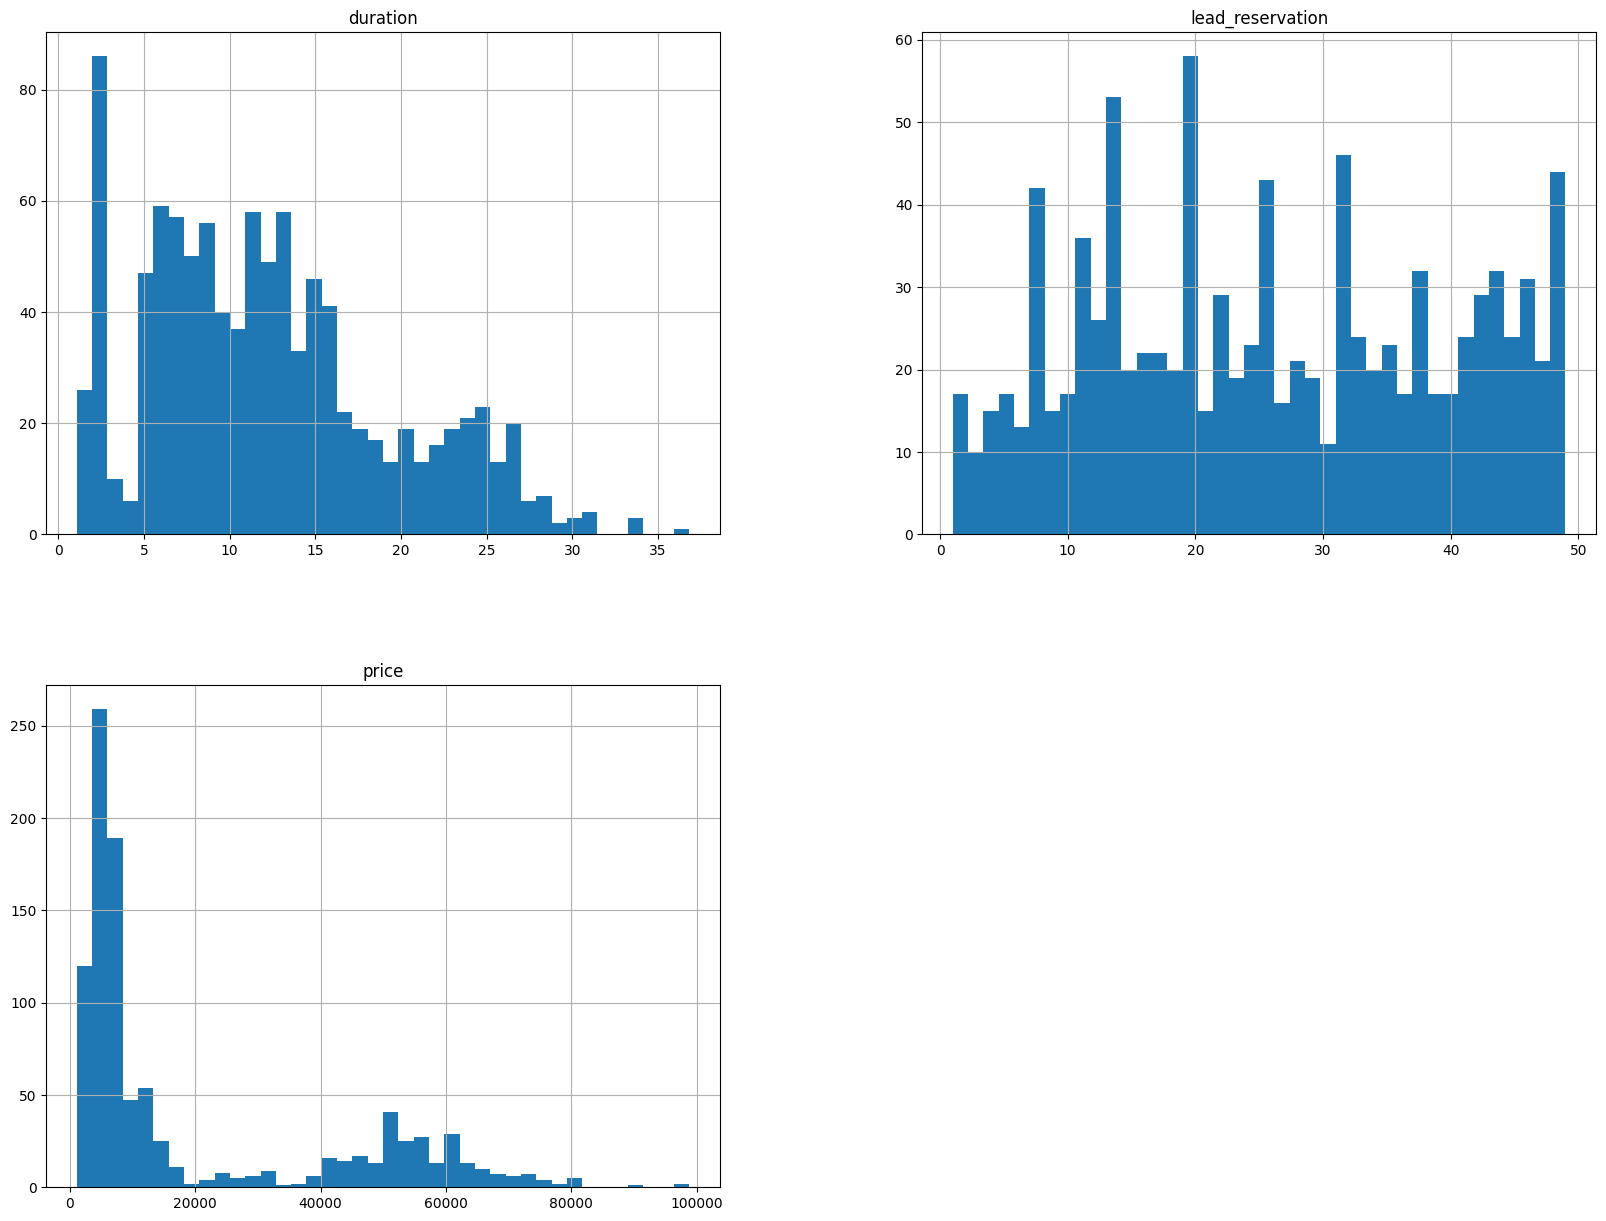

In [620]:
%matplotlib inline
import matplotlib.pyplot as plt
flight.hist(bins=40, figsize=(20,15))
plt.show()

**Detect and Remove outliers** 

<Axes: xlabel='lead_reservation'>

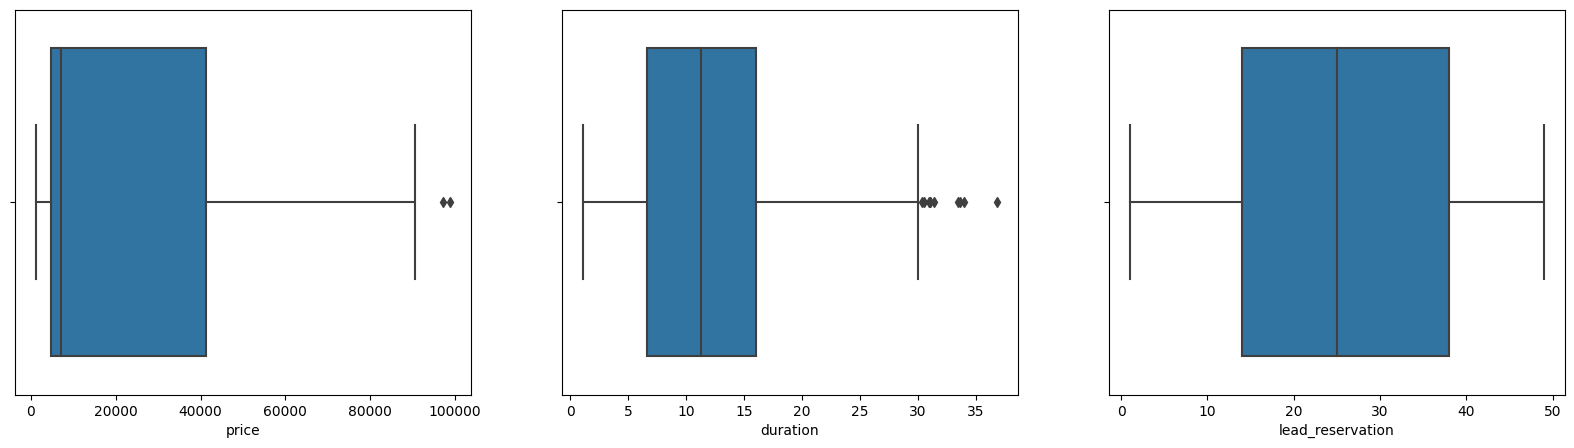

In [621]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

In [622]:
Q1 = flight.quantile(0.25)
Q3 = flight.quantile(0.75)
IQR = Q3 - Q1
flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]

<ipython-input-622-63ea7a9fe649>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]


<Axes: xlabel='lead_reservation'>

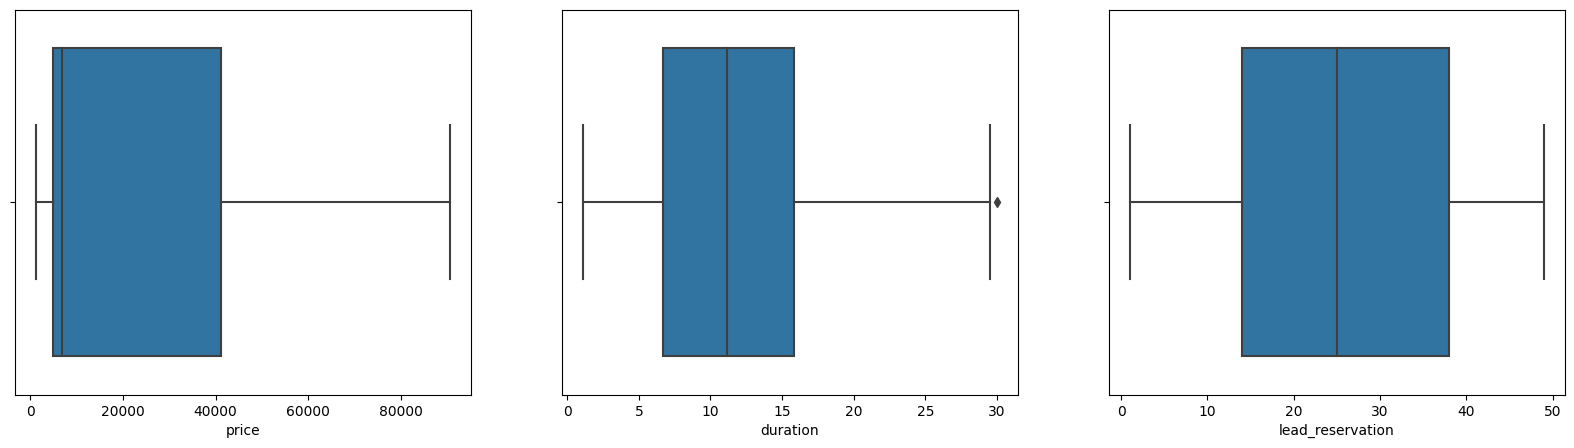

In [623]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['duration'], ax=axs[1])
sns.boxplot(x=flight['lead_reservation'], ax=axs[2])

we will use the StratifiedShuffleSplit to split the data keeping the same distribution of class category.

In [624]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 27131 to 75274
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           988 non-null    object 
 1   source_city       988 non-null    object 
 2   departure_time    988 non-null    object 
 3   stops             988 non-null    object 
 4   arrival_time      988 non-null    object 
 5   destination_city  988 non-null    object 
 6   class             988 non-null    object 
 7   duration          988 non-null    float64
 8   lead_reservation  988 non-null    int64  
 9   price             988 non-null    float64
dtypes: float64(2), int64(1), object(7)
memory usage: 84.9+ KB


In [625]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
flight['airline'] = encoder.fit_transform(flight['airline'])
flight['source_city'] = encoder.fit_transform(flight['source_city'])
flight['departure_time'] = encoder.fit_transform(flight['departure_time'])
flight['stops'] = encoder.fit_transform(flight['stops'])
flight['arrival_time'] = encoder.fit_transform(flight['arrival_time'])
flight['destination_city'] = encoder.fit_transform(flight['destination_city'])
flight['class'] = encoder.fit_transform(flight['class'])

In [626]:
flight.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
27131,1,2,4,0,1,4,1,19.75,40,7366.0
266857,5,4,4,0,5,5,0,9.83,42,64831.0
141228,5,4,4,0,5,0,1,10.50,41,6195.0
288329,5,1,5,0,4,2,0,14.50,14,60160.0
97334,1,0,0,0,5,5,1,8.25,20,6578.0


In [627]:
flight["lead_reservation"].value_counts

<bound method IndexOpsMixin.value_counts of 27131     40
266857    42
141228    41
288329    14
97334     20
          ..
168951    34
145671    29
152235    45
280954    14
75274     36
Name: lead_reservation, Length: 988, dtype: int64>

In [628]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 27131 to 75274
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           988 non-null    int64  
 1   source_city       988 non-null    int64  
 2   departure_time    988 non-null    int64  
 3   stops             988 non-null    int64  
 4   arrival_time      988 non-null    int64  
 5   destination_city  988 non-null    int64  
 6   class             988 non-null    int64  
 7   duration          988 non-null    float64
 8   lead_reservation  988 non-null    int64  
 9   price             988 non-null    float64
dtypes: float64(2), int64(8)
memory usage: 84.9 KB


### **Get the size of taining set and test set**

In [629]:
#using Scikit-Learn train_test_split()
train_set, test_set = train_test_split(flight, test_size=0.2, random_state=42)
print("size of training data",len(train_set))
print("size of testing data",len(test_set))

size of training data 790
size of testing data 198


**Correlation matrix**

In [630]:
##flight = strat_train_set.copy()
corr_matrix= flight.corr()
corr_matrix["price"].sort_values(ascending=False)

price               1.000000
duration            0.295674
airline             0.244324
arrival_time        0.022784
destination_city    0.010026
departure_time      0.003110
source_city        -0.000441
lead_reservation   -0.070553
stops              -0.193822
class              -0.942458
Name: price, dtype: float64

In [631]:
corr_matrix

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
airline,1.000000,0.010568,0.008132,-0.049738,-0.002853,-0.091207,-0.177312,0.008827,0.008086,0.244324
source_city,0.010568,1.000000,0.030041,-0.018780,0.024919,-0.251785,0.011517,0.036891,0.015329,-0.000441
departure_time,0.008132,0.030041,1.000000,0.083422,-0.033203,-0.060068,-0.000154,0.092415,-0.010437,0.003110
stops,-0.049738,-0.018780,0.083422,1.000000,0.014823,-0.024982,0.095516,-0.488860,-0.034972,-0.193822
arrival_time,-0.002853,0.024919,-0.033203,0.014823,1.000000,-0.046358,-0.011034,0.036092,0.000686,0.022784
destination_city,-0.091207,-0.251785,-0.060068,-0.024982,-0.046358,1.000000,-0.001237,0.012494,-0.049957,0.010026
class,-0.177312,0.011517,-0.000154,0.095516,-0.011034,-0.001237,1.000000,-0.231251,-0.014222,-0.942458
duration,0.008827,0.036891,0.092415,-0.488860,0.036092,0.012494,-0.231251,1.000000,-0.013219,0.295674
lead_reservation,0.008086,0.015329,-0.010437,-0.034972,0.000686,-0.049957,-0.014222,-0.013219,1.000000,-0.070553
price,0.244324,-0.000441,0.003110,-0.193822,0.022784,0.010026,-0.942458,0.295674,-0.070553,1.000000


In [632]:
print(flight["stops"].isnull().sum())

0


array([[<Axes: xlabel='duration', ylabel='duration'>,
        <Axes: xlabel='lead_reservation', ylabel='duration'>,
        <Axes: xlabel='price', ylabel='duration'>],
       [<Axes: xlabel='duration', ylabel='lead_reservation'>,
        <Axes: xlabel='lead_reservation', ylabel='lead_reservation'>,
        <Axes: xlabel='price', ylabel='lead_reservation'>],
       [<Axes: xlabel='duration', ylabel='price'>,
        <Axes: xlabel='lead_reservation', ylabel='price'>,
        <Axes: xlabel='price', ylabel='price'>]], dtype=object)

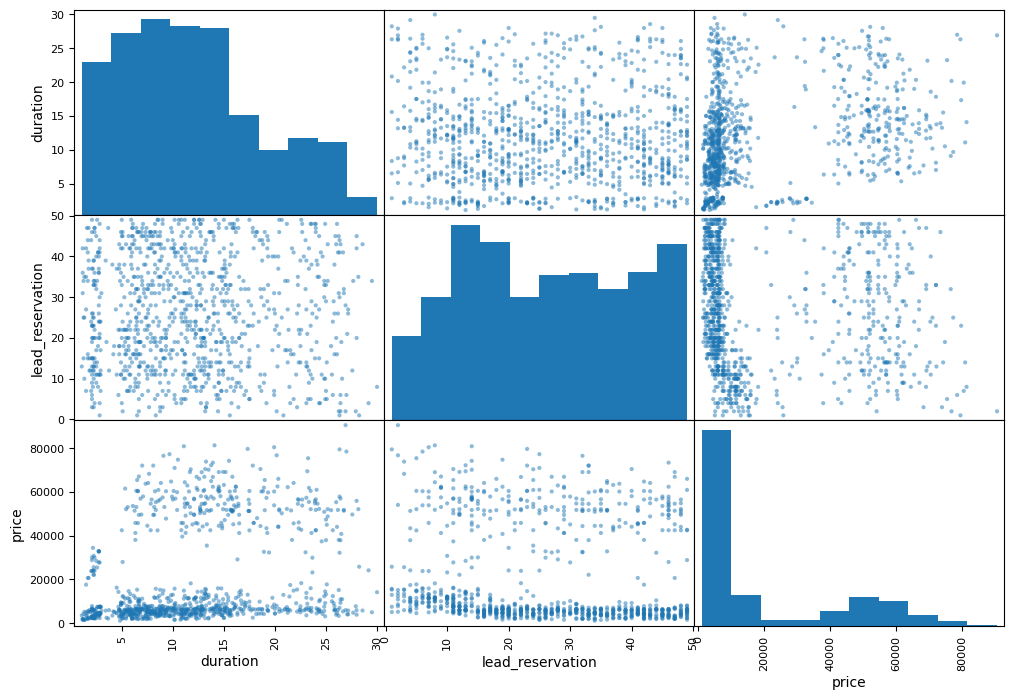

In [633]:
from pandas.plotting import scatter_matrix
attributes=["duration","lead_reservation","price"]
scatter_matrix(flight[attributes], figsize=(12,8))

### **Random Forest**

In [634]:
flightX = train_set.drop("price", axis =1)
flightY = train_set["price"].copy()
X_train, X_test, y_train, y_test = train_test_split(flightX, flightX, test_size=0.2, random_state=42)

In [635]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(flightX,flightY)
forest_price_predicitons= forest_reg.predict(flightX)
regr_score = forest_reg.score(flightX, flightY)
forest_mse= mean_squared_error(flightY, forest_price_predicitons)
forest_rmse= np.sqrt(forest_mse)
forest_rmse

1928.6536088034331

In [636]:
print("Accuracy: ", regr_score)

Accuracy:  0.9925492125086752


In [637]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [638]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_reg,flightX,flightY, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores= np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [5059.19493375 6199.82970296 3907.92766287 6467.57927626 4224.35879735
 5135.22858111 4590.1479748  5075.82361399 5511.12221699 4816.42659866]
Mean: 5098.763935874545
Standard Deviation: 760.298769526395


In [640]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(flightX, flightY) #train the model
price_predictions = tree_reg.predict(flightX) #predict
tree_score = tree_reg.score(flightX, flightY)
tree_mse = mean_squared_error (flightY, price_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [641]:
print("Accuracy: ", tree_score)

Accuracy:  1.0


In [537]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, flightX, flightY, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [538]:
display_scores(tree_rmse_scores)

Scores: [7045.82576846 8965.27598042 6471.32486582 9208.09032484 6498.20029515
 6556.58698842 6455.14977912 7153.95733984 6151.10000351 6170.79198803]
Mean: 7067.630333360743
Standard Deviation: 1055.984428861093
